In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from PIL import Image, ImageOps
import seaborn as sns
import pandas as pd
import nibabel as nib
import skimage.io as io
import numpy as np
import SimpleITK as sitk
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torchvision import transforms, utils

In [2]:
def iou(y_pre, y_true):
    y_pre = y_pre.flatten().astype(int)
    y_true = y_true.flatten().astype(int)
    I = np.bitwise_and(y_pre, y_true).sum().item()
    U = np.bitwise_or(y_pre, y_true).sum().item()
    if U == 0:
        return 0
    if I > U:
        print('iou counting error')
    return float(I)/U

def create_poly(seg, rt):
    masks = np.zeros((seg.shape))
    mask = seg #* 255.0
    x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for s in ct:
        approx = cv2.approxPolyDP(s, rt*cv2.arcLength(s, True), True)
        temp = np.zeros((seg.shape))
        tempSum = cv2 .fillPoly(temp,[approx],1)
        if np.sum(tempSum) < 50:
            continue
        cv2 .fillPoly(masks,[approx],(255,255,255))
    re = np.array(masks)
    i = iou(re, mask)
    return re, i

def create_box(mask):
    masks = np.zeros(mask.shape)
    mask = mask 
    x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for s in ct:
        x,y,w,h = cv2.boundingRect(s)
        if w * h < 100 or w <5 or h<5:
            continue
        cv2.rectangle(masks, (x, y), (x + w, y + h), 1, -1)
    np.array(masks)
    i = iou(masks, mask)
    return masks, i

def filter(mask, ksize):
    mask = Image.fromarray(mask).resize((256,256))
    x = cv2.cvtColor(np.asarray(mask.convert('RGB')).astype(np.uint8), cv2.COLOR_RGB2BGR)
    mask = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    temp = mask.copy()
    for i in range(10):
        temp = cv2.blur(temp, (ksize,ksize))
    masks = cv2.threshold(temp, 0.5*np.max(temp), 1, cv2.THRESH_BINARY)[1]
    masks = np.array(masks)
    i = iou(masks, mask)
    return masks, i

In [45]:
y = np.load(r"p_test/p.npy", allow_pickle=True)
print(len(y))
print(y[0])

20
['1' 'Taichi_S4_C1_00135.png']


In [69]:
imgFile  = r"p_test"
y = np.load(r"p_test/p.npy", allow_pickle=True)
iouList = []
for i in range(12):
    segName = r"seg_{}.png".format(y[i][1][:-4])
    seg = Image.open(os.path.join(imgFile, segName))
    seg = np.array(seg)
    seg = np.array([0 if i == 0 else 1 for i in seg.flatten()]).reshape(seg.shape)
    seg = seg[:,:,0]
    seg2,ii = create_box(seg)
    iouList.append(ii)
print(np.mean(iouList))

0.4311624011697131


In [77]:
imgFile  = r"p_test"
y = np.load(r"p_test/p.npy", allow_pickle=True)
iouList = []
for i in range(12):
    segName = r"seg_{}.png".format(y[i][1][:-4])
    seg = Image.open(os.path.join(imgFile, segName))
    seg = np.array(seg)
    seg = np.array([0 if i == 0 else 1 for i in seg.flatten()]).reshape(seg.shape)
    seg = seg[:,:,0]
    seg2,ii = filter(seg,13)
    iouList.append(ii)
print(np.mean(iouList))

0.7268792571968049


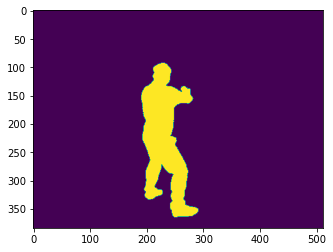

In [72]:
plt.imshow(seg)

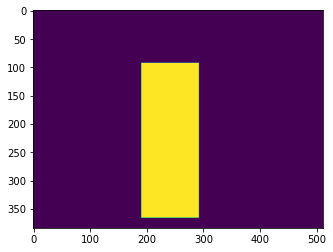

In [74]:
plt.imshow(seg2)

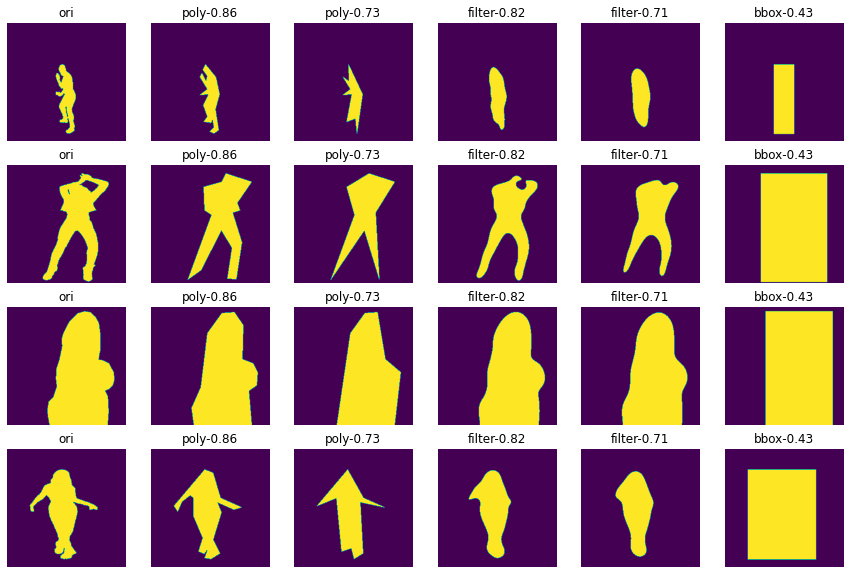

In [81]:
imgFile  = r"p_test"
y = np.load(r"p_test/p.npy", allow_pickle=True)
plt.figure(figsize=(15,10))
iouList = []
for j, i in enumerate([0,1,5,8]):
    segName = r"seg_{}.png".format(y[i][1][:-4])
    seg = Image.open(os.path.join(imgFile, segName))
    seg = seg.resize((256,256))
    seg = np.array(seg)
    seg = seg[:,:,0]
    seg = np.array([0 if i == 0 else 255 for i in seg.flatten()]).reshape(seg.shape)
    plt.subplot(4,6,6*j+1)
    plt.imshow(seg)
    plt.axis('off')
    plt.title('ori')
    seg2,ii = create_poly(seg, 0.01)
    iouList.append(ii)
    plt.subplot(4,6,6*j+2)
    plt.imshow(seg2.astype(int))
    plt.axis('off')
    plt.title('poly-0.86')
    seg3,ii = create_poly(seg, 0.02)
    iouList.append(ii)
    plt.subplot(4,6,6*j+3)
    plt.imshow(seg3.astype(int))
    plt.axis('off')
    plt.title('poly-0.73')
    seg4,ii = filter(seg, 9)
    iouList.append(ii)
    plt.subplot(4,6,6*j+4)
    plt.imshow(seg4.astype(int))
    plt.axis('off')
    plt.title('filter-0.82')
    seg5,ii = filter(seg, 13)
    iouList.append(ii)
    plt.subplot(4,6,6*j+5)
    plt.imshow(seg5.astype(int))
    plt.axis('off')
    plt.title('filter-0.71')
    seg6,ii = create_box(seg)
    iouList.append(ii)
    plt.subplot(4,6,6*j+6)
    plt.imshow(seg6.astype(int))
    plt.axis('off')
    plt.title('bbox-0.43')
    

In [53]:
print(np.mean(iouList))

0.8571634600943788


255 (384, 512, 3)


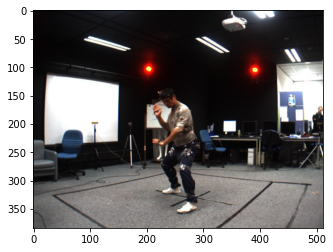

In [48]:
segName = r"{}".format(y[0][1])
seg = Image.open(os.path.join(imgFile, segName))
seg = np.array(seg)
print(np.max(seg),seg.shape)
plt.imshow(seg)

In [87]:
imgFile  = r"water/water_v2/water_v2/river_test"
y = np.load(r"water/water_v2/water_v2/river_test/river_test.npy", allow_pickle=True)
iouList = []
for i in range(12):
    segName = r"{}.png".format(y[i][:-4])
    seg = Image.open(os.path.join(imgFile, segName))
    seg = np.array(seg)
    seg = np.array([0 if i == 0 else 1 for i in seg.flatten()]).reshape(seg.shape)
    seg = seg[:,:,0]
    #seg2,ii = filter(seg,31)
    seg2,ii = create_box(seg)
    iouList.append(ii)
print(np.mean(iouList))

0.6351185302320758


In [3]:
y = np.load(r"water/water_v2/water_v2/\river_test/river_test.npy", allow_pickle=True)
print(len(y))
print(y[0])

20
00013.jpg


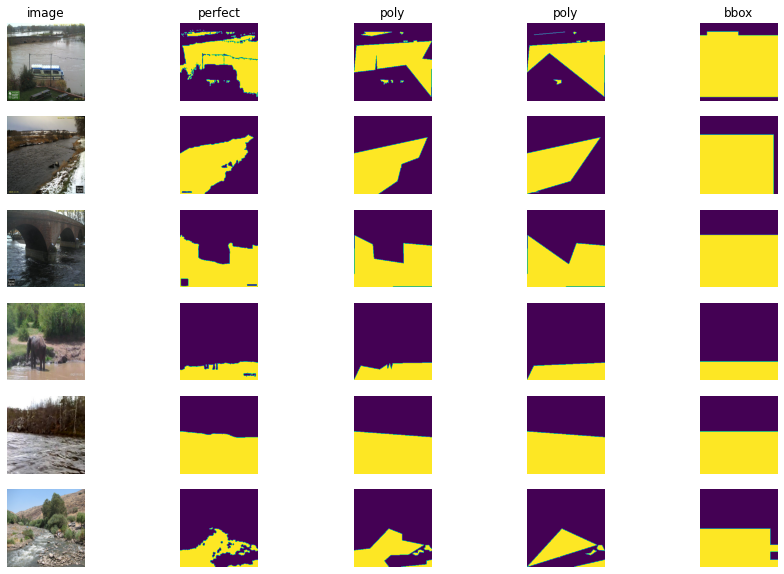

In [6]:
imgFile  = r"water/water_v2/water_v2/river_test"
plt.figure(figsize=(15,10))
iouList = []
for j, i in enumerate(range(6)):
    segName = r"{}".format(y[i])
    seg = Image.open(os.path.join(imgFile, segName))
    seg = seg.resize((256,256))
    plt.subplot(6,5,5*j+1)
    plt.imshow(seg)
    if i ==0:
        plt.title('image')
    plt.axis('off')
    segName = r"{}.png".format(y[i][:-4])
    seg = Image.open(os.path.join(imgFile, segName))
    seg = seg.resize((256,256))
    seg = np.array(seg)
    seg = seg[:,:,0]
    seg = np.array([0 if i == 0 else 255 for i in seg.flatten()]).reshape(seg.shape)
    plt.subplot(6,5,5*j+2)
    plt.imshow(seg)
    plt.axis('off')
    if i ==0:
        plt.title('perfect')
    seg2,ii = create_poly(seg, 0.02)
    iouList.append(ii)
    plt.subplot(6,5,5*j+3)
    plt.imshow(seg2.astype(int))
    plt.axis('off')
    if i ==0:
        plt.title('poly')
    seg3,ii = create_poly(seg, 0.05)
    iouList.append(ii)
    plt.subplot(6,5,5*j+4)
    plt.imshow(seg3.astype(int))
    plt.axis('off')
    if i ==0:
        plt.title('poly')
    seg6,ii = create_box(seg)
    iouList.append(ii)
    plt.subplot(6,5,5*j+5)
    plt.imshow(seg6.astype(int))
    plt.axis('off')
    if i ==0:
        plt.title('bbox')


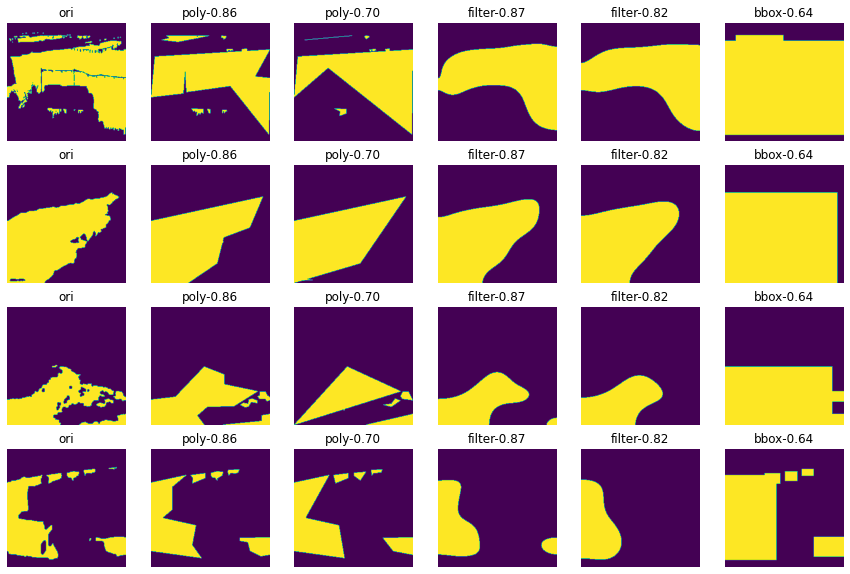

In [93]:
imgFile  = r"water/water_v2/water_v2/river_test"
plt.figure(figsize=(15,10))
iouList = []
for j, i in enumerate([0,1,5,10]):
    segName = r"{}.png".format(y[i][:-4])
    seg = Image.open(os.path.join(imgFile, segName))
    seg = seg.resize((256,256))
    seg = np.array(seg)
    seg = seg[:,:,0]
    seg = np.array([0 if i == 0 else 255 for i in seg.flatten()]).reshape(seg.shape)
    plt.subplot(4,6,6*j+1)
    plt.imshow(seg)
    plt.axis('off')
    plt.title('ori')
    seg2,ii = create_poly(seg, 0.02)
    iouList.append(ii)
    plt.subplot(4,6,6*j+2)
    plt.imshow(seg2.astype(int))
    plt.axis('off')
    plt.title('poly-0.86')
    seg3,ii = create_poly(seg, 0.05)
    iouList.append(ii)
    plt.subplot(4,6,6*j+3)
    plt.imshow(seg3.astype(int))
    plt.axis('off')
    plt.title('poly-0.70')
    seg4,ii = filter(seg, 21)
    iouList.append(ii)
    plt.subplot(4,6,6*j+4)
    plt.imshow(seg4.astype(int))
    plt.axis('off')
    plt.title('filter-0.87')
    seg5,ii = filter(seg, 31)
    iouList.append(ii)
    plt.subplot(4,6,6*j+5)
    plt.imshow(seg5.astype(int))
    plt.axis('off')
    plt.title('filter-0.82')
    seg6,ii = create_box(seg)
    iouList.append(ii)
    plt.subplot(4,6,6*j+6)
    plt.imshow(seg6.astype(int))
    plt.axis('off')
    plt.title('bbox-0.64')

    

In [43]:
print(np.mean(iouList))

0.701169037479415


In [32]:
segName = r"{}.png".format(y[0][:-4])
seg = Image.open(os.path.join(imgFile, segName))
seg = np.array(seg)
seg = np.array([0 if i == 0 else 255 for i in seg.flatten()]).reshape(seg.shape)

255 (768, 1024, 3)


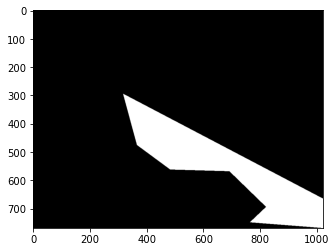

In [39]:
seg2,ii = create_poly(seg, 0.02)
seg2 = seg2.astype(int)
print(np.max(seg2),seg2.shape)
plt.imshow(seg2)

In [33]:
print(np.max(seg),seg.shape)

255 (480, 640, 3)


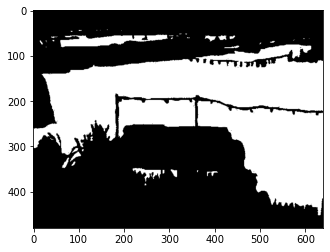

In [34]:
plt.imshow(seg)

In [97]:
imgFile  = r"btrat/brat_sample"
y = np.load(r"btrat/brat_test2.npy", allow_pickle=True).item()
iouList = []
for i in range(12):
    segName = r"{}_seg.nii".format(y[i][0])
    seg = sitk.ReadImage(os.path.join(imgFile, segName))
    seg = sitk.GetArrayFromImage(seg)
    seg = seg[y[i][1]]
    seg = np.array([0 if i == 0 else 1 for i in seg.flatten()]).reshape(seg.shape)
    seg = Image.fromarray(seg)
    seg = seg.resize((256,256))
    seg = np.array(seg)
    seg2,ii = filter(seg,9)
    # seg2,ii = create_box(seg)
    iouList.append(ii)
print(np.mean(iouList))

0.7386447585490163


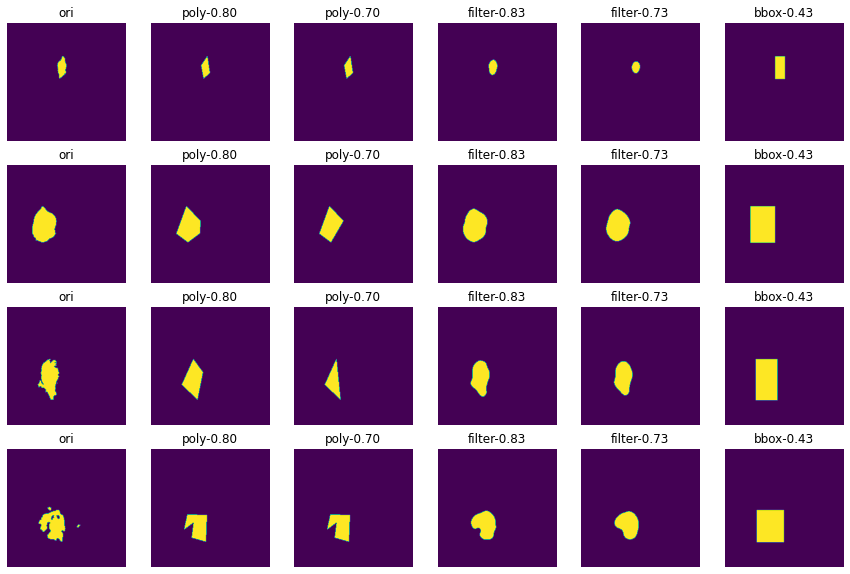

In [100]:
imgFile  = r"btrat/brat_sample"
plt.figure(figsize=(15,10))
iouList = []
for j, i in enumerate([1,3,7,11]):
    segName = r"{}_seg.nii".format(y[i][0])
    seg = sitk.ReadImage(os.path.join(imgFile, segName))
    seg = sitk.GetArrayFromImage(seg)
    seg = seg[y[i][1]]
    
#     seg = Image.fromarray(seg)
#     seg = seg.resize((256,256))
#     seg = np.array(seg)
    seg = np.array([0 if i == 0 else 1 for i in seg.flatten()]).reshape(seg.shape)

    plt.subplot(4,6,6*j+1)
    plt.imshow(seg)
    plt.axis('off')
    plt.title('ori')
    seg2,ii = create_poly(seg, 0.04)
    iouList.append(ii)
    plt.subplot(4,6,6*j+2)
    plt.imshow(seg2.astype(int))
    plt.axis('off')
    plt.title('poly-0.80')
    seg3,ii = create_poly(seg, 0.06)
    iouList.append(ii)
    plt.subplot(4,6,6*j+3)
    plt.imshow(seg3.astype(int))
    plt.axis('off')
    plt.title('poly-0.70')
    seg4,ii = filter(seg, 7)
    iouList.append(ii)
    plt.subplot(4,6,6*j+4)
    plt.imshow(seg4.astype(int))
    plt.axis('off')
    plt.title('filter-0.83')
    seg5,ii = filter(seg, 9)
    iouList.append(ii)
    plt.subplot(4,6,6*j+5)
    plt.imshow(seg5.astype(int))
    plt.axis('off')
    plt.title('filter-0.73')
    seg6,ii = create_box(seg)
    iouList.append(ii)
    plt.subplot(4,6,6*j+6)
    plt.imshow(seg6.astype(int))
    plt.axis('off')
    plt.title('bbox-0.43')
    

In [13]:
print(iouList)
print(np.mean(iouList))

[0.7489473684210526, 0.8460144927536232, 0.731006160164271, 0.7221786833855799, 0.75678391959799, 0.7215909090909091, 0.7301250294880868, 0.5172413793103449, 0.7714285714285715, 0.5437881873727087, 0.7663656884875847, 0.7234320557491289]
0.7149085371041543
